In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from functions import get_energy_cost
from functions import energy_model
from functions import poly_features_model
from functions import slope_computing
from functions import build_node_graph

# Ingestion

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Columns: 683 entries, 0 to 682
dtypes: float64(683)
memory usage: 2.9 MB


None

max:  1780.29
min:  673.22
mean:  1200.5576816744215
median:  1240.315


Text(0.9, -0.2, 'All measurements in meters [m]')

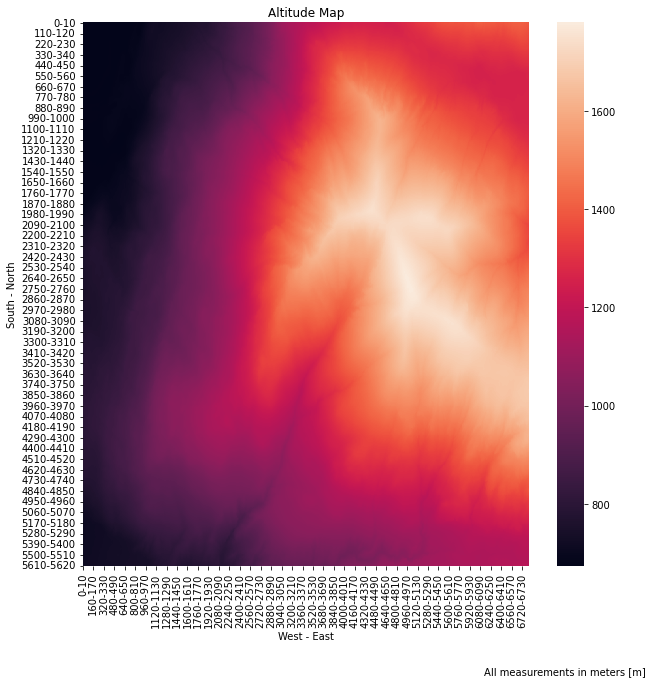

In [2]:
df_alt_map = pd.read_csv('data/altitude_map (1).csv',header=None) # reading map info (altitude in [m])
display(df_alt_map.info())
# Checking for outliers and skewness
print("max: ",df_alt_map.max().max())
print("min: ",df_alt_map.min().min())
print("mean: ",df_alt_map.mean().mean())
print("median: ",df_alt_map.median().median())
# No evident outliers seen
# Height seems to have a normal distribution
# Data type is consistent
assert df_alt_map.isnull().sum().sum() == 0 # Check on empty values
# No missing values
df_alt_map.index = [f"{elem*10}-{elem*10+10}" for elem in df_alt_map.index] # set y_orig axis resolution (10m)
df_alt_map.columns = [f"{elem*10}-{elem*10+10}" for elem in df_alt_map.columns] # set x axis resolution (10m)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_alt_map)
ax.set(xlabel='West - East', ylabel='South - North',title='Altitude Map')
ax.text(0.9, -0.2, 'All measurements in meters [m]', transform=ax.transAxes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gradient     65 non-null     float64
 1   energy_cost  65 non-null     float64
dtypes: float64(2)
memory usage: 1.1 KB


None

'max: '

gradient        0.458577
energy_cost    17.383337
dtype: float64

'min: '

gradient      -0.459229
energy_cost    0.455766
dtype: float64

'mean: '

gradient      -0.000129
energy_cost    6.307908
dtype: float64

'median: '

gradient      -0.002166
energy_cost    3.497927
dtype: float64

Text(0, 0.5, 'energy_cost [ J / (Kg*min)]')

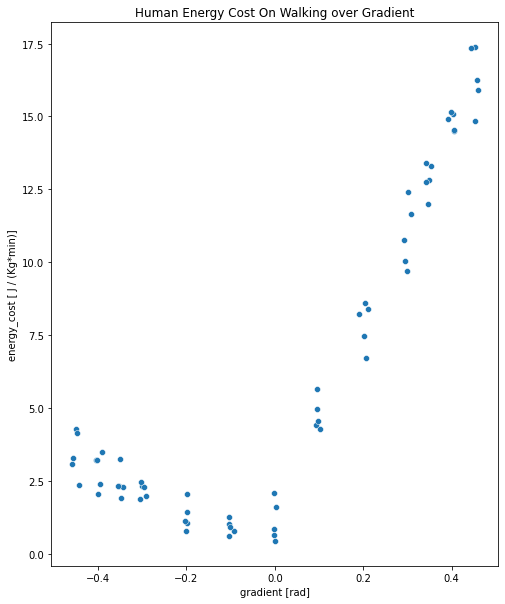

In [3]:
df_ener_cost = pd.read_csv('data/energy_cost.csv') # reading energy cost on slope walking
display(df_ener_cost.info())
# Checking for outliers and skewness
display("max: ",df_ener_cost.max())
display("min: ",df_ener_cost.min())
display("mean: ",df_ener_cost.mean())
display("median: ",df_ener_cost.median())
fig, ax = plt.subplots(figsize=(8, 10))
sns.scatterplot(data=df_ener_cost, x="gradient", y="energy_cost")
ax.set(title='Human Energy Cost On Walking over Gradient')
plt.xlabel('gradient [rad]')
plt.ylabel('energy_cost [ J / (Kg*min)]')

# Modelling

## Polynomial regression

Multiple degrees of polynomial were evaluated using MSE.

A degree of 4 was finally chosen since it reduced substantially the fitting error while not overfitting on sample data

In [4]:
x_orig = df_ener_cost.loc[:,'gradient'].values.reshape(-1, 1)
y_orig = df_ener_cost.loc[:,'energy_cost'].values.reshape(-1, 1)

# Evaluating best (non overfitting value)
for degree in range(9):
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(x_orig)
    # Train
    model = LinearRegression()
    model.fit(x_poly, y_orig)
    # EVALUATE MSE
    y_pred = model.predict(x_poly)
    mse = mean_squared_error(y_orig, y_pred)
    print(f"Mean Squared Error for degree {degree}: {mse}")

# Create polynomial features
degree = 4
poly_features = PolynomialFeatures(degree=degree)
x_poly = poly_features.fit_transform(x_orig)
# Train
model = LinearRegression()
model.fit(x_poly, y_orig)
# EVALUATE MSE
y_pred = model.predict(x_poly)
mse = mean_squared_error(y_orig, y_pred)
# SAVING THE MODEL
joblib.dump(model, 'models/energy_model.pkl')
joblib.dump(poly_features, 'models/poly_features_model.pkl')

Mean Squared Error for degree 0: 29.20858348239694
Mean Squared Error for degree 1: 7.984462630525669
Mean Squared Error for degree 2: 0.7545854881751669
Mean Squared Error for degree 3: 0.717681978252707
Mean Squared Error for degree 4: 0.48118299960013944
Mean Squared Error for degree 5: 0.47697906605976725
Mean Squared Error for degree 6: 0.459020102962174
Mean Squared Error for degree 7: 0.4309812855099043
Mean Squared Error for degree 8: 0.39604379542434687


['models/poly_features_model.pkl']

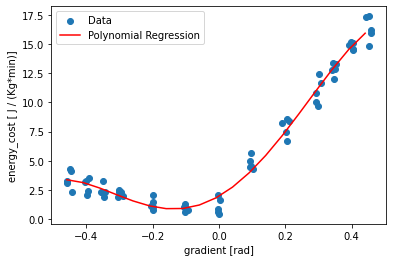

In [5]:
# VISUALIZING THE MODEL FIT
# Predict on new data
min_indep = df_ener_cost.loc[:,'gradient'].min()
max_indep = df_ener_cost.loc[:,'gradient'].max()
X_new = np.arange(min_indep, max_indep, 0.05).reshape(-1, 1)
X_new_poly = poly_features.transform(X_new)
y_pred = model.predict(X_new_poly)
# Visualize the results
plt.scatter(x_orig, y_orig, label='Data')
plt.plot(X_new, y_pred, color='red', label='Polynomial Regression')
plt.xlabel('gradient [rad]')
plt.ylabel('energy_cost [ J / (Kg*min)]')
plt.legend()
plt.show()

# Optimisation
Node approximation approach implemented

In [7]:
df_alt_map = pd.read_csv('data/altitude_map test.csv',header=None) # reading map info (altitude in [m])
display("test mini map: ",df_alt_map)

node_graph=nx.Graph()
build_node_graph(df_alt_map,node_graph)
print("Route:")
nx.shortest_path(node_graph, '(4,2)', '(0,0)', weight='weight')

'test mini map: '

,0,1,2,3,4,5
0,0,6,0,1,2,3
1,0,6,5,4,0,0
2,0,6,6,3,2,0
3,0,0,1,1,1,0
4,0,1,0,1,0,1


Route:


['(4,2)', '(4,1)', '(4,0)', '(3,0)', '(2,0)', '(1,0)', '(0,0)']

In [5]:
df_alt_map = pd.read_csv('data/altitude_map test.csv',header=None) # reading map info (altitude in [m])
display("test mini map: ",df_alt_map)

node_graph=nx.Graph()
build_node_graph(df_alt_map,node_graph)
print("Route:")
nx.shortest_path(node_graph, '(4,2)', '(0,0)', weight='weight')


['(4,2)', '(4,1)', '(4,0)', '(3,0)', '(2,0)', '(1,0)', '(0,0)']